In [1]:
import os
import sys
one_level_up_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(one_level_up_dir)
import jax._src.random as prng
import jax
from jax import config, jit
import jax.numpy as jnp
import jax.random as jr
import diffrax as dfx
import matplotlib.pyplot as plt
import optax as ox
import equinox as eqx
from gpdx.systems.nonlinear_dynamics import VanDerPol
from gpdx.control.trajectory_optimizers import *
from gpdx.control.cost_functions import QuadraticCost
# from gpdx.dataset import DiffEqDataset
from gpdx.nn.node import NeuralODE, EnsembleNeuralODE
from gpdx.nn.nnvectorfield import NeuralVectorField, EnsembleNeuralVectorField

from gpdx.fit import *
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
PRNGKey = prng.KeyArray
key = jr.PRNGKey(123) 
key, subkey = jr.split(key)
%load_ext autoreload
%autoreload 2

In [2]:
from gpdx.control.control_task import DuffingStabilization
env = DuffingStabilization()
env


DuffingStabilization(
  real_system=DuffingOscillator(
    D_sys=2,
    D_control=1,
    solver=Dopri8(scan_kind=None),
    name='Duffing Oscillator',
    control_interpolator='linear',
    alpha=-1.0,
    beta=2.0,
    delta=0.2,
    gamma=1.0,
    omega=5.0
  ),
  D_sys=2,
  D_control=1,
  R=f64[1,1],
  Q=f64[2,2],
  x_star=f64[2],
  u_star=f64[1],
  y0=f64[2],
  t0=0.0,
  tf=5.0,
  Delta_t=0.05,
  measurement_noise_std=0.01,
  lb=-2.0,
  ub=2.0,
  state_cost=QuadraticCost(
    Q=f64[2,2],
    R=f64[1,1],
    x_star=f64[2],
    u_star=f64[1],
    transform=None
  ),
  termination_cost=QuadraticCost(
    Q=f64[2,2],
    R=f64[1,1],
    x_star=f64[2],
    u_star=f64[1],
    transform=None
  ),
  H=None,
  Q_f=f64[2,2],
  name='Van der Pol stabilization control task',
  S=1.0
)

## data generation

In [3]:
# initial state distribution
real_system = env.real_system
# x0_distribution = lambda key: jnp.array([1.,1.])#.1*(jr.uniform(key=key, shape=(2,))-0.5)
key, subkey = jr.split(key)
t0 = env.t0
tf = env.tf

## Compute mean objective with SQP

traj. opt. times:  [0.097, 0.016, 0.0096, 0.0115, 0.0055, 0.0075, 0.0047, 0.0026, 0.0063, 0.0057]


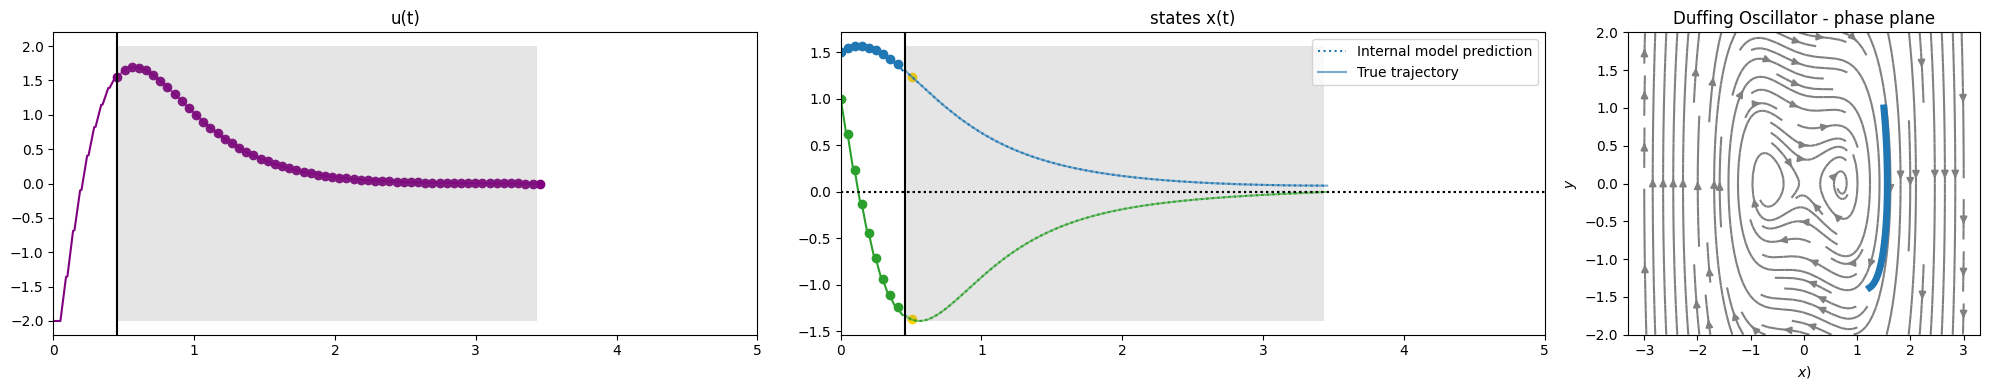

traj. opt. times:  [0.0032, 0.0039, 0.0026, 0.0029, 0.0038, 0.0032, 0.0035, 0.0032, 0.0035, 0.0031]


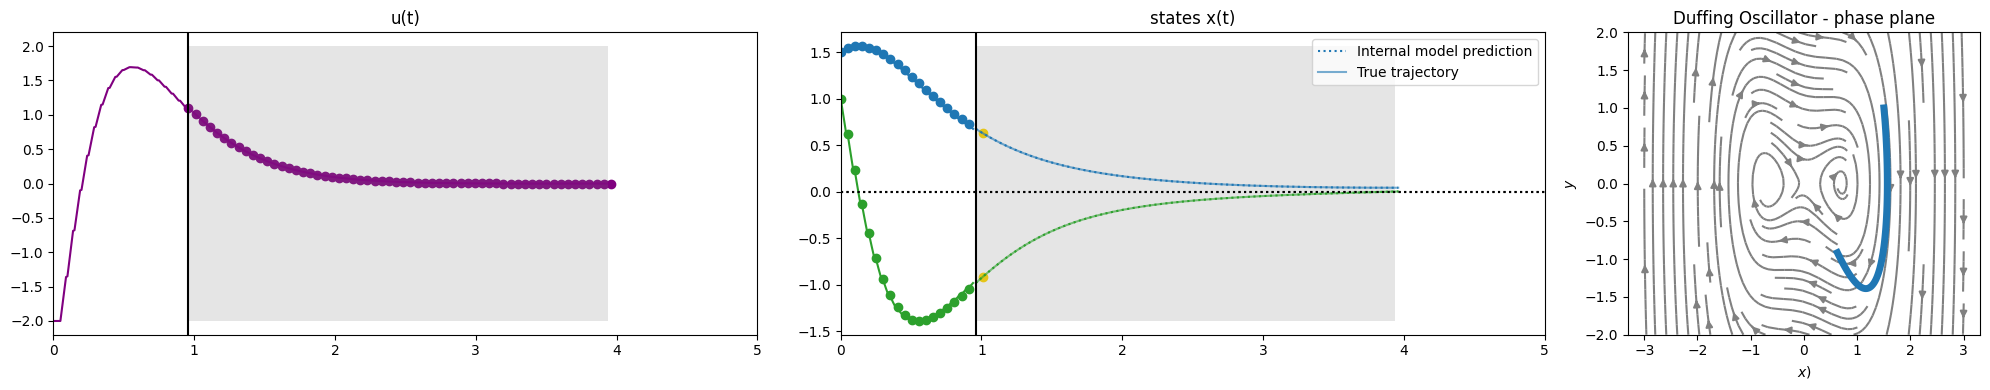

traj. opt. times:  [0.0051, 0.0038, 0.0034, 0.0035, 0.0039, 0.0035, 0.0034, 0.0034, 0.0032, 0.0032]


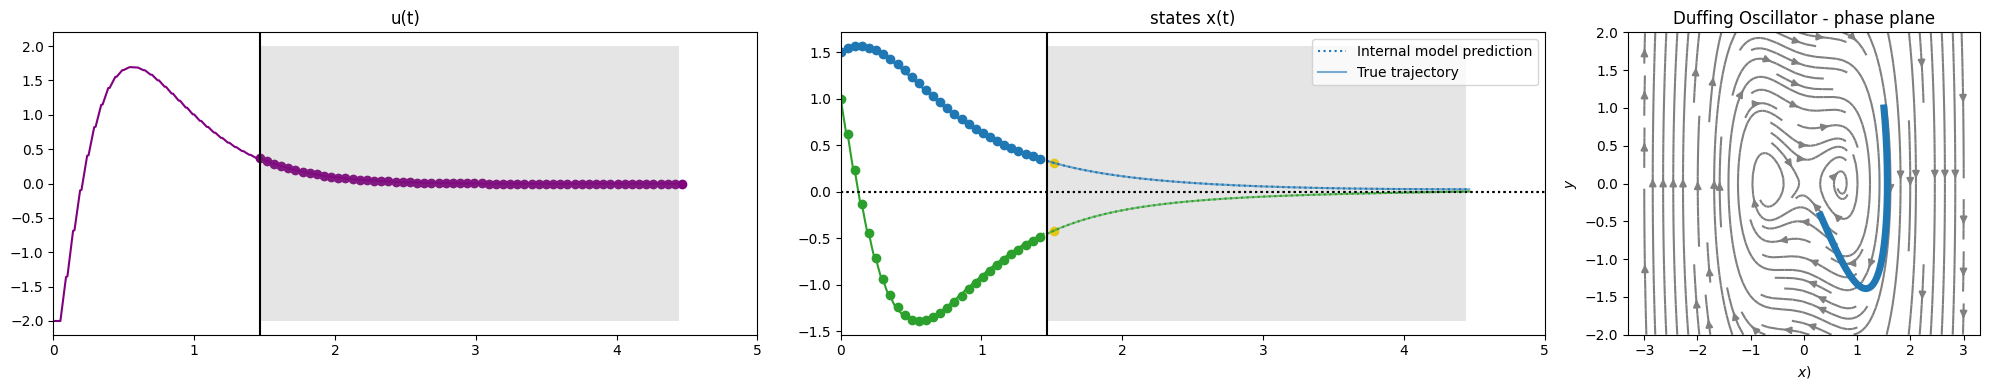

traj. opt. times:  [0.0086, 0.0029, 0.0038, 0.0034, 0.0047, 0.0034, 0.0069, 0.0058, 0.0033, 0.0037]


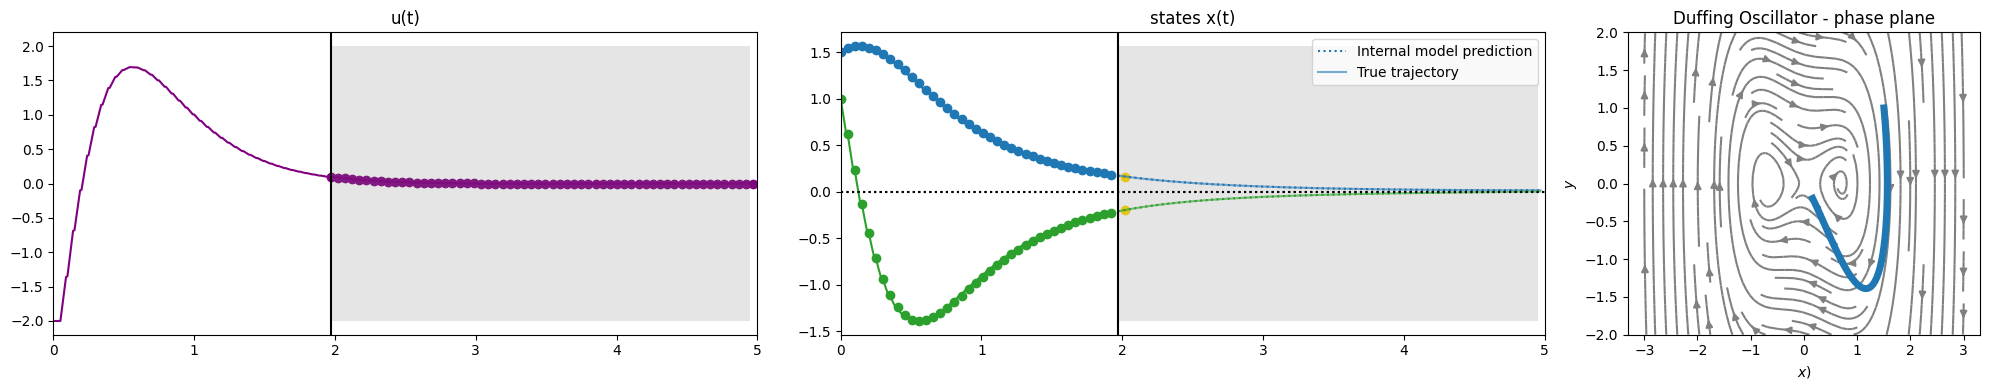

traj. opt. times:  [0.0049, 0.0029, 0.0034, 0.0027, 0.0025, 0.0026, 0.003, 0.003, 0.0025, 0.0029]


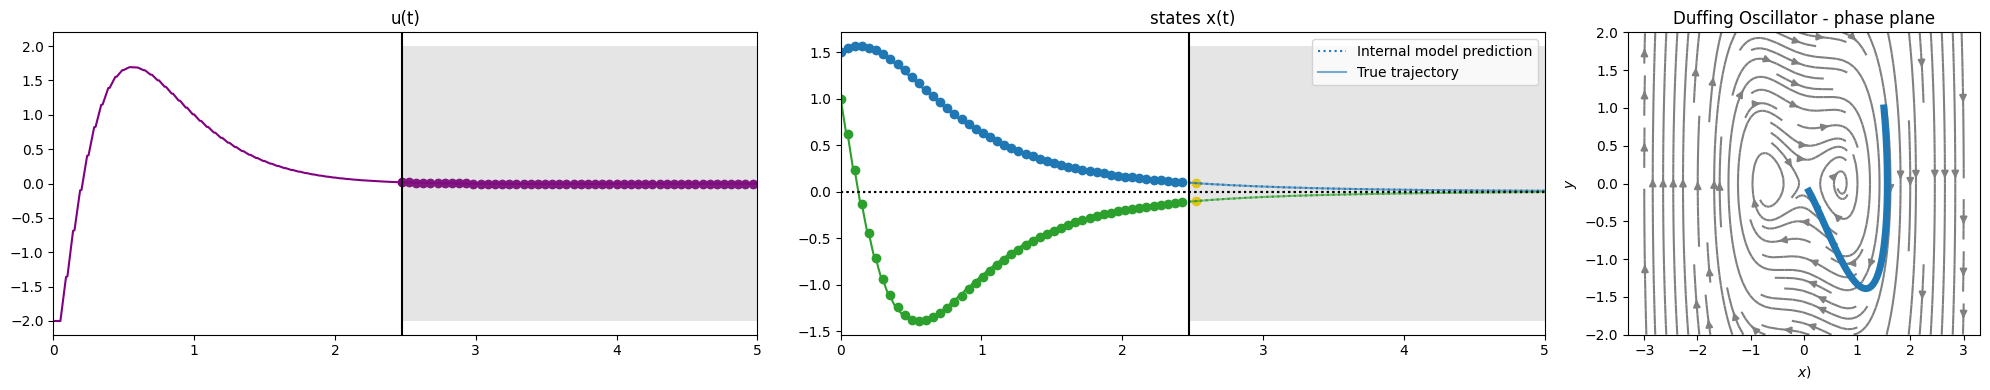

traj. opt. times:  [0.0185, 0.0029, 0.0032, 0.0024, 0.0029, 0.0026, 0.003, 0.0028, 0.0032, 0.0026]


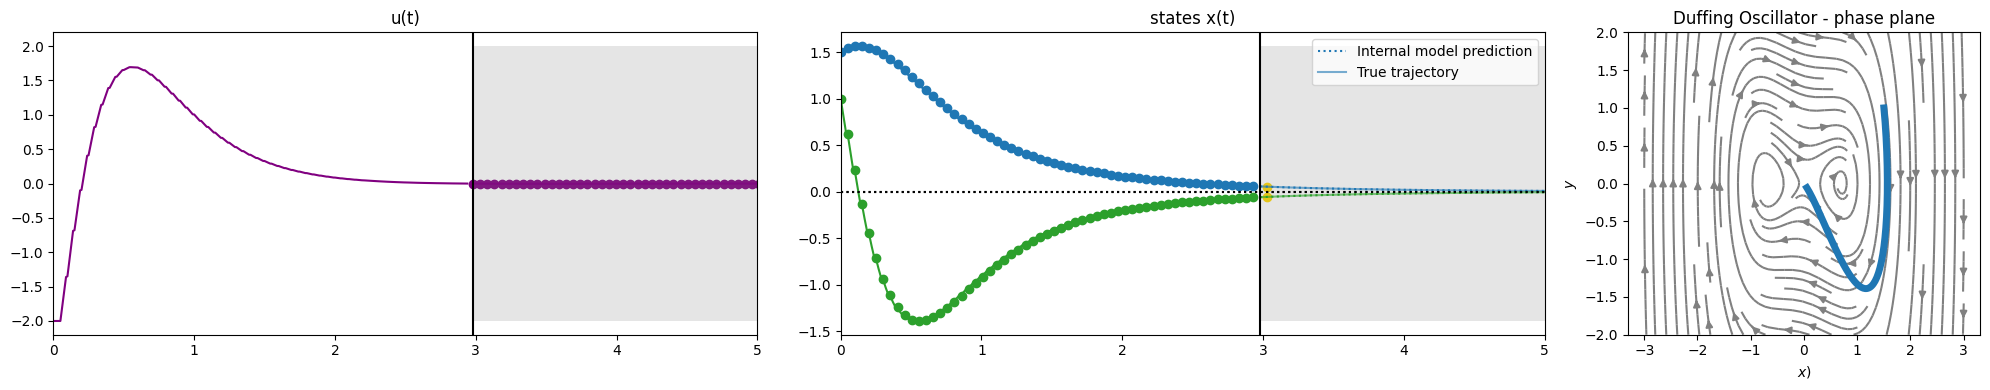

traj. opt. times:  [0.0055, 0.0029, 0.0053, 0.0033, 0.003, 0.0025, 0.0028, 0.0028, 0.0038, 0.0031]


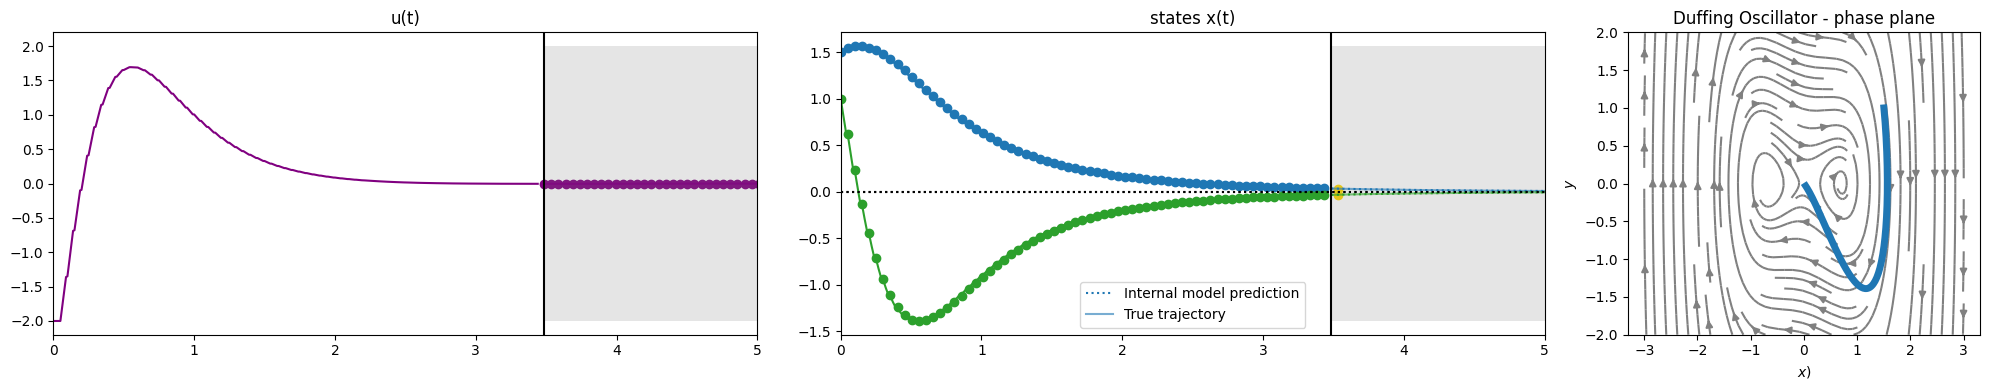

traj. opt. times:  [0.0052, 0.0029, 0.003, 0.0027, 0.0026, 0.0033, 0.0025, 0.0026, 0.0027, 0.0025]


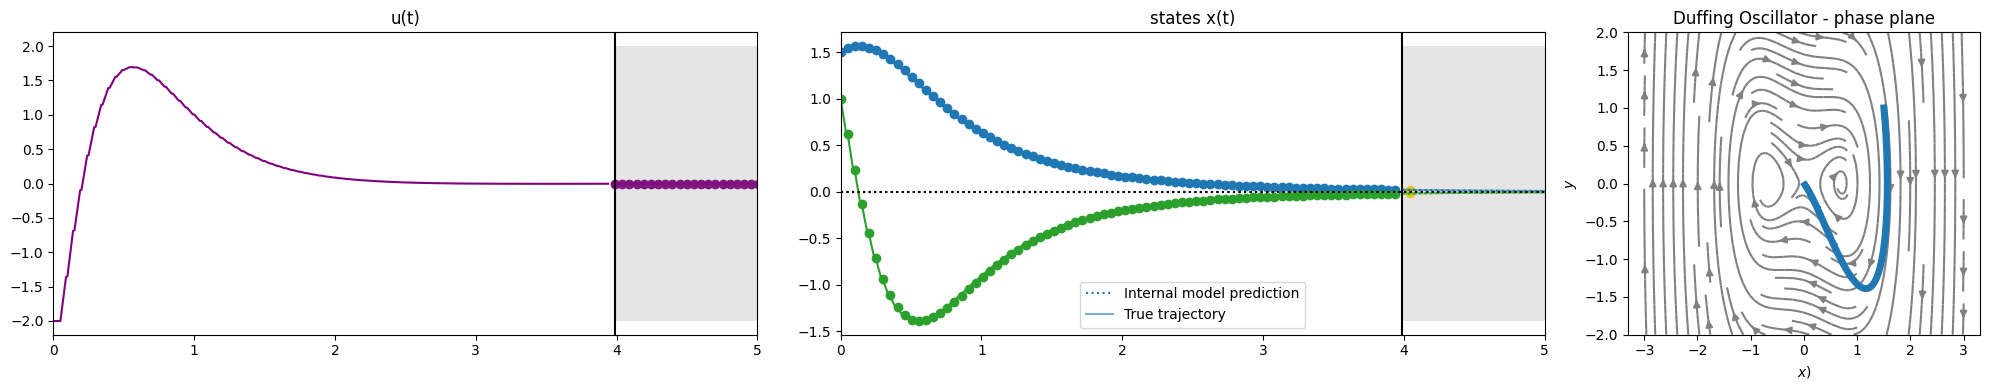

traj. opt. times:  [0.0038, 0.0032, 0.0027, 0.0018, 0.0029, 0.0016, 0.003, 0.0017, 0.003, 0.0017]


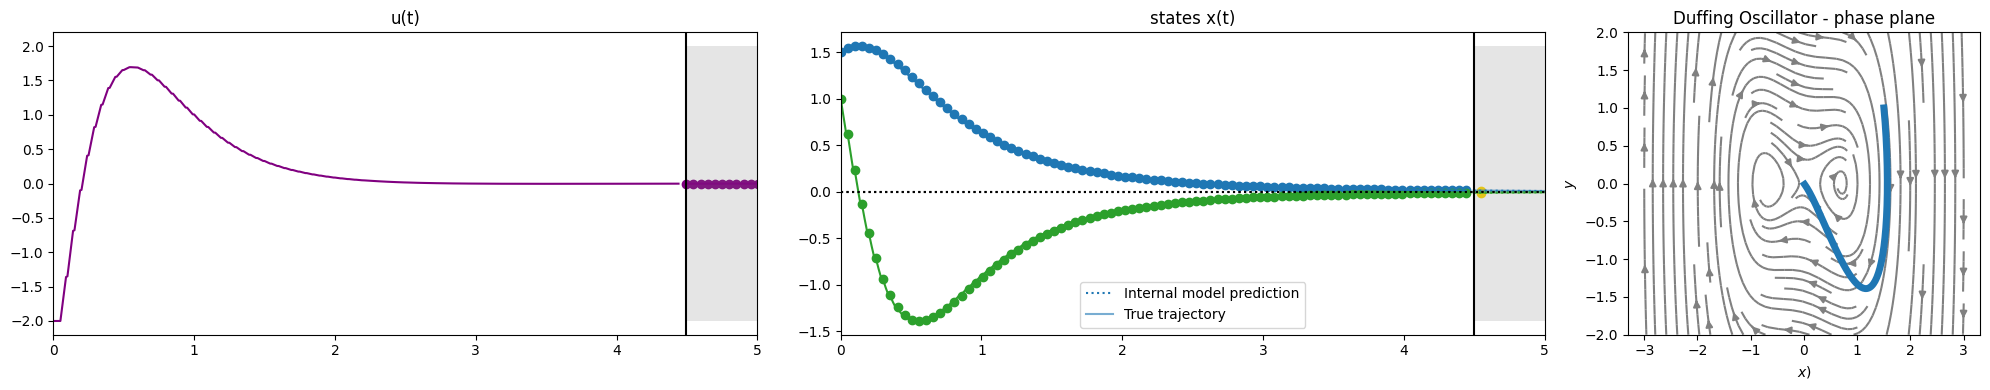

traj. opt. times:  [0.0065, 0.0126, 0.0137, 0.0054, 0.0029, 0.0027, 0.0033, 0.0033, 0.0056, 0.0021]


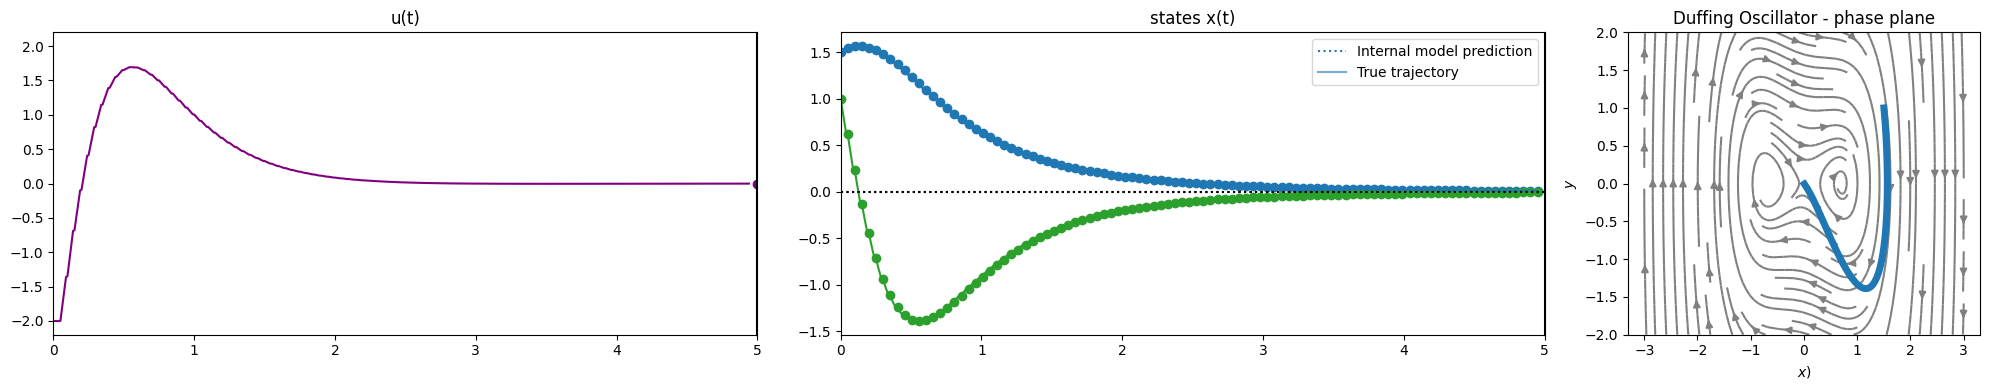

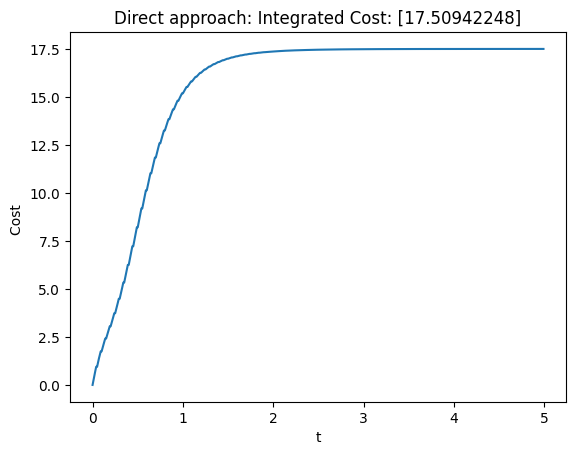

In [4]:

maxiter = 15
from gpdx.control.mpc import *
H = 3.
us_init = 0.*jr.normal(key=subkey**2, shape=(jnp.arange(0, H, env.Delta_t).shape[0], 1))
key, subkey = jr.split(key)

sqp_solver = SLSQP(
                # pop_size=500, 
                # elite_size=50,
                # init_var=4,
            lb=env.lb*jnp.ones_like(us_init),
            ub=env.ub*jnp.ones_like(us_init),
            maxiter=maxiter,)
cem_solver = CEM(pop_size=500,
                 elite_size = int(0.13*500),
                 alpha=0.3, 
                 init_var = 1., 
                lb=env.lb*jnp.ones_like(us_init),
                ub=env.ub*jnp.ones_like(us_init),
                maxiter=maxiter,)

true_mpc = MPC(
        traj_optimizer=sqp_solver,
        real_system=env.real_system,
        internal_system=env.real_system,
        state_cost=env.state_cost,
        termination_cost=env.termination_cost,
        verbose=True,
        )

ts, ts_dense, X, Y, U, R = true_mpc.simulate(x0=env.get_initial_condition(),
        ts=jnp.linspace(env.t0, env.tf, int( ((1/env.Delta_t))*(tf-t0))),
        Delta_t=env.Delta_t,
        dt0_dense=1e-2,
        x_star=env.x_star,
        H=H, 
        )



plt.plot(ts_dense, R)
plt.title(f'Direct approach: Integrated Cost: {R[-1]}')
plt.ylabel('Cost ')
plt.xlabel('t')
plt.show()

## Indirect approach

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization (iteration 10) not succesfull, continuing.
Initial optimization (iteration 11) not succesfull, continuing.
Initial optimization (iteration 12) not succesfull, continuing.
Initial optimization (iteration 13) not succesfull, continuing.
Initial optimization (iteration 14) not succesfull, continuing.
Initial optimization (iteration 15) not succesfull

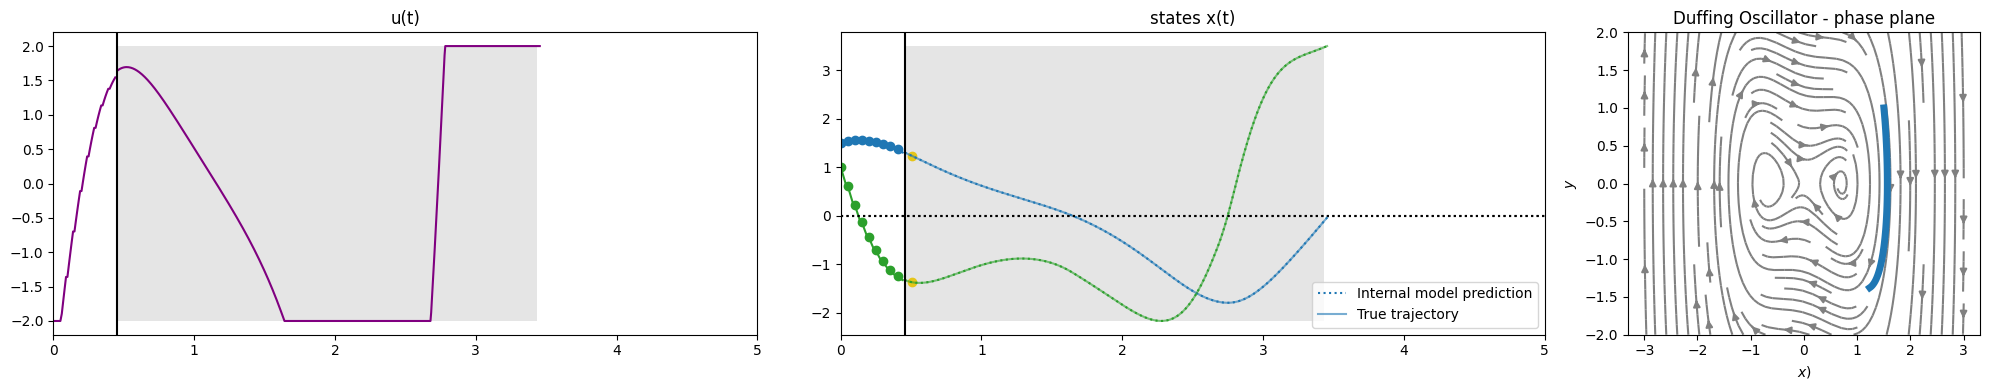

Traj. opt. times:  [(0.0494, Array(11, dtype=int64, weak_type=True)), (0.0212, Array(11, dtype=int64, weak_type=True)), (0.0238, Array(11, dtype=int64, weak_type=True)), (0.0191, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True)), (0.0196, Array(11, dtype=int64, weak_type=True)), (0.0204, Array(11, dtype=int64, weak_type=True)), (0.0192, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True))]


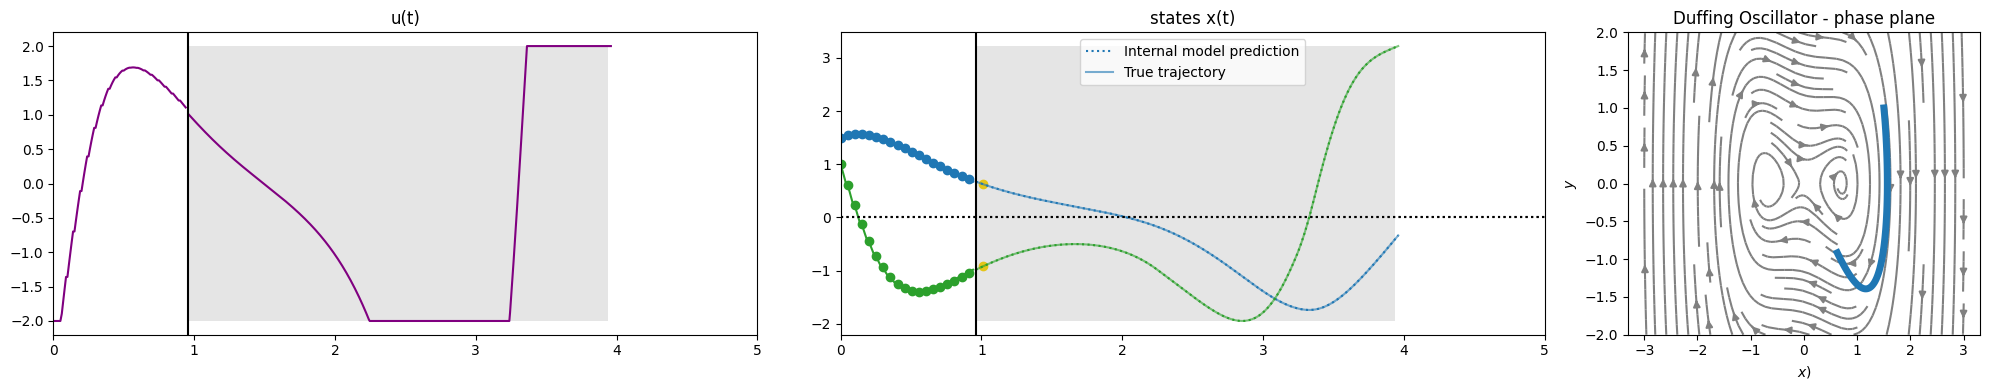

Traj. opt. times:  [(0.0255, Array(11, dtype=int64, weak_type=True)), (0.0199, Array(11, dtype=int64, weak_type=True)), (0.0231, Array(11, dtype=int64, weak_type=True)), (0.0191, Array(11, dtype=int64, weak_type=True)), (0.0202, Array(11, dtype=int64, weak_type=True)), (0.0202, Array(11, dtype=int64, weak_type=True)), (0.0228, Array(11, dtype=int64, weak_type=True)), (0.0225, Array(11, dtype=int64, weak_type=True)), (0.0217, Array(11, dtype=int64, weak_type=True)), (0.0194, Array(11, dtype=int64, weak_type=True))]


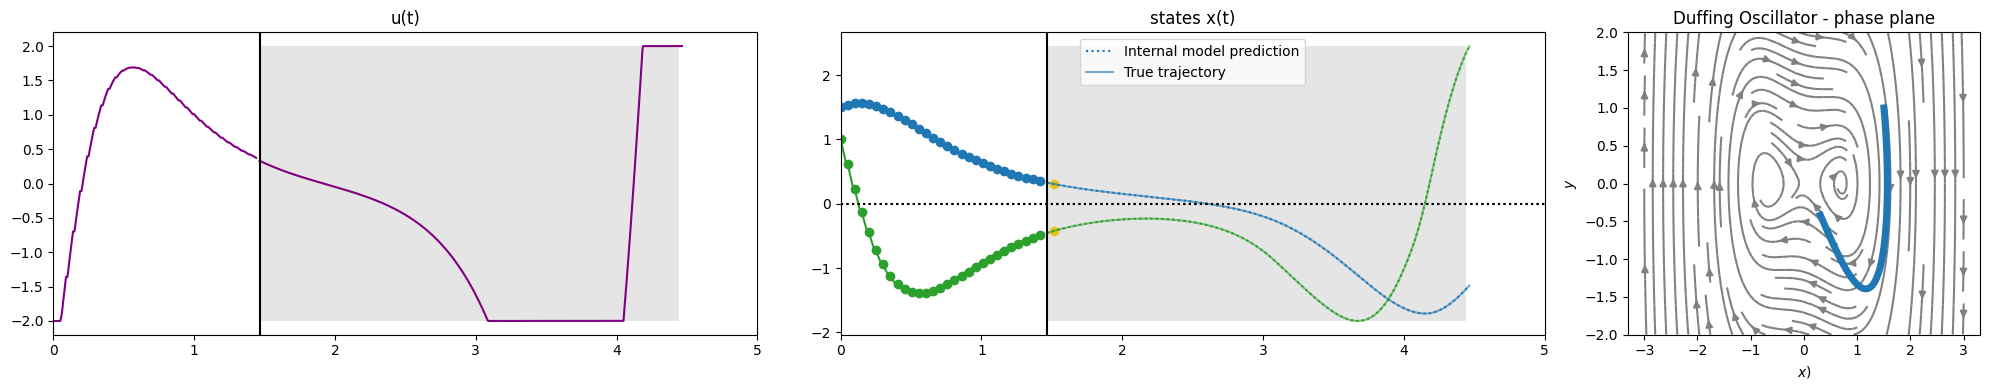

Traj. opt. times:  [(0.0337, Array(11, dtype=int64, weak_type=True)), (0.0213, Array(11, dtype=int64, weak_type=True)), (0.0212, Array(11, dtype=int64, weak_type=True)), (0.0221, Array(11, dtype=int64, weak_type=True)), (0.0373, Array(11, dtype=int64, weak_type=True)), (0.0268, Array(11, dtype=int64, weak_type=True)), (0.0393, Array(11, dtype=int64, weak_type=True)), (0.0262, Array(11, dtype=int64, weak_type=True)), (0.0226, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True))]


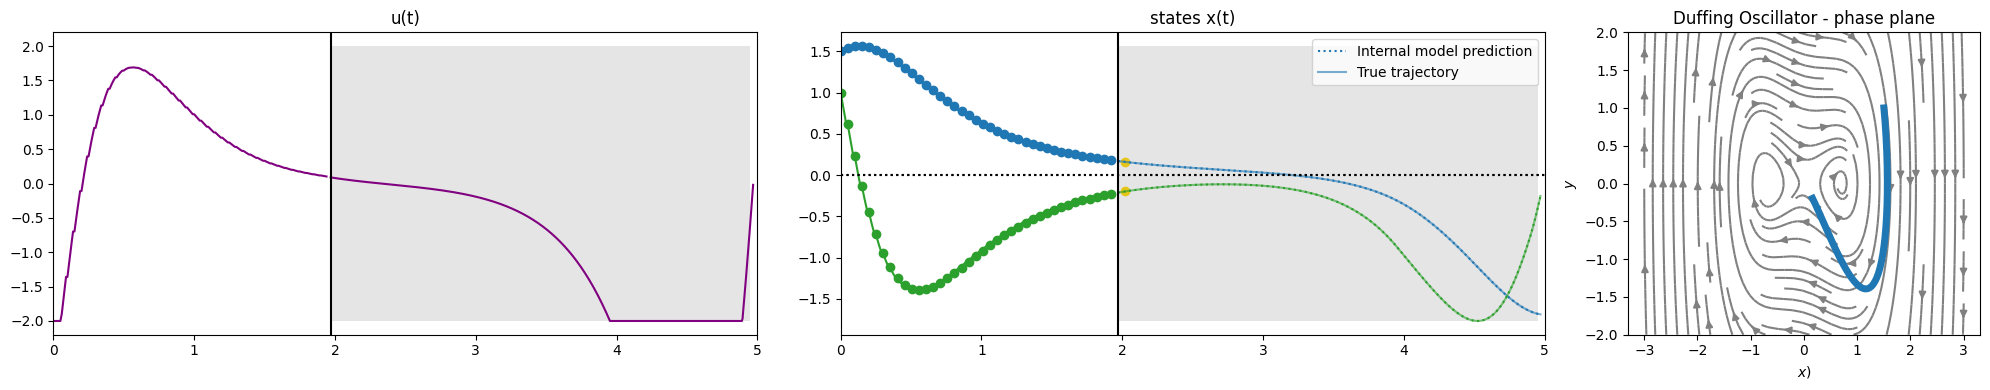

Traj. opt. times:  [(0.0527, Array(11, dtype=int64, weak_type=True)), (0.0205, Array(11, dtype=int64, weak_type=True)), (0.0241, Array(11, dtype=int64, weak_type=True)), (0.0289, Array(11, dtype=int64, weak_type=True)), (0.0221, Array(11, dtype=int64, weak_type=True)), (0.0224, Array(11, dtype=int64, weak_type=True)), (0.0194, Array(11, dtype=int64, weak_type=True)), (0.0187, Array(11, dtype=int64, weak_type=True)), (0.0194, Array(11, dtype=int64, weak_type=True)), (0.0193, Array(11, dtype=int64, weak_type=True))]


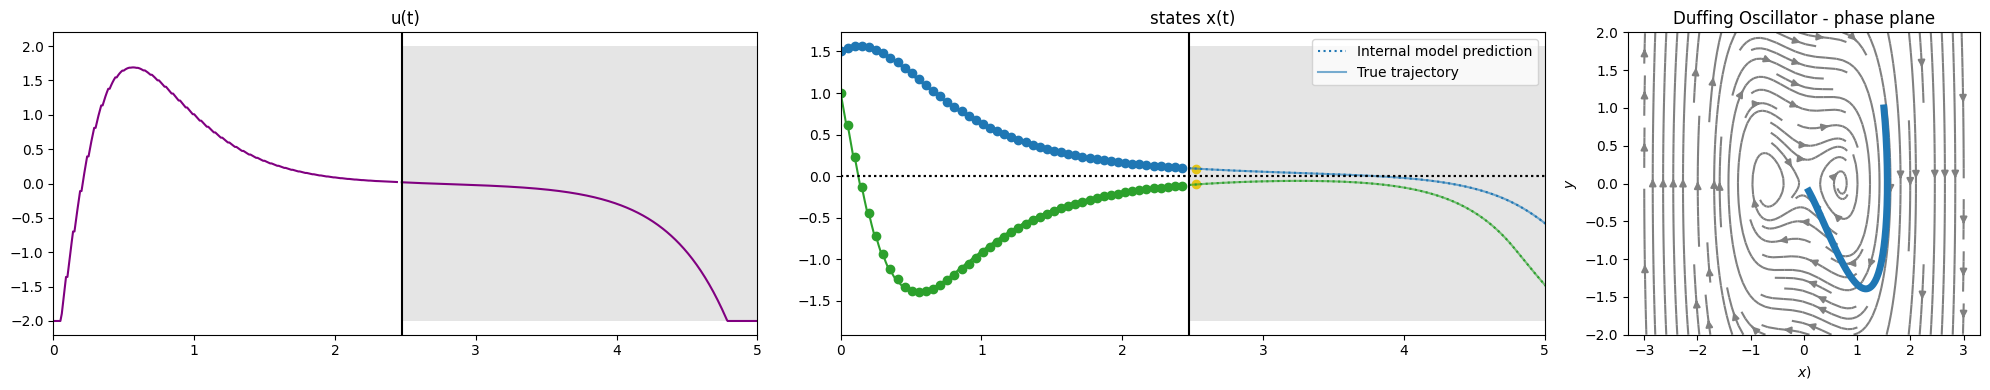

Traj. opt. times:  [(0.0378, Array(11, dtype=int64, weak_type=True)), (0.0201, Array(11, dtype=int64, weak_type=True)), (0.0201, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True)), (0.0204, Array(11, dtype=int64, weak_type=True)), (0.02, Array(11, dtype=int64, weak_type=True)), (0.0207, Array(11, dtype=int64, weak_type=True)), (0.0207, Array(11, dtype=int64, weak_type=True)), (0.0225, Array(11, dtype=int64, weak_type=True)), (0.0352, Array(11, dtype=int64, weak_type=True))]


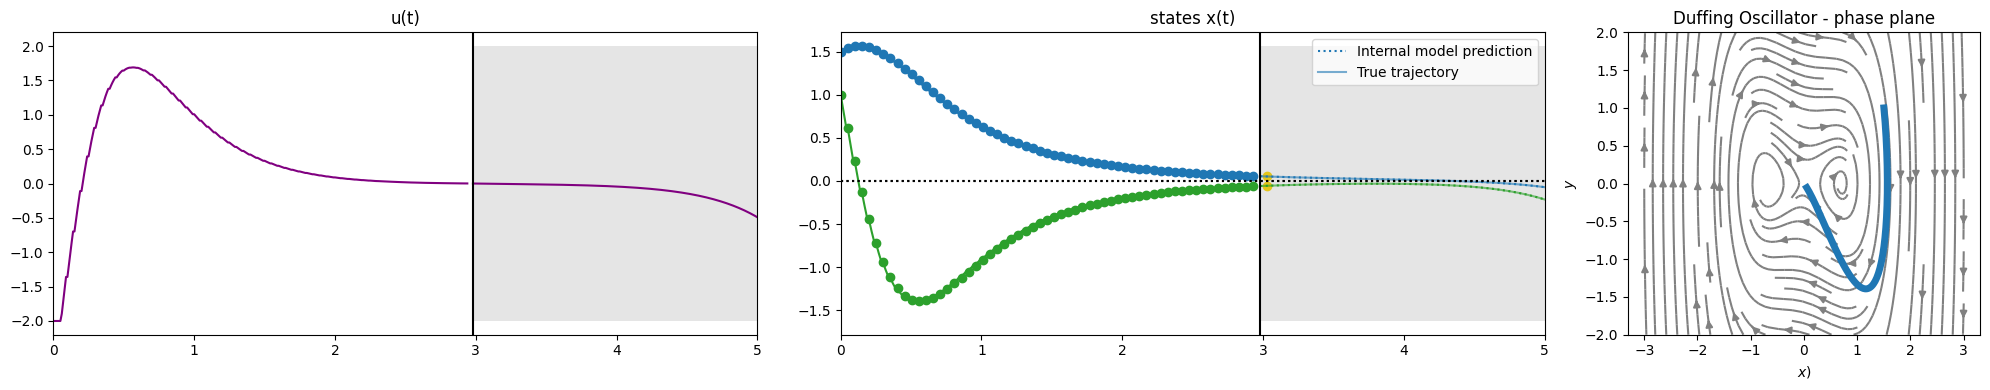

Traj. opt. times:  [(0.0305, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True)), (0.0207, Array(11, dtype=int64, weak_type=True)), (0.0209, Array(11, dtype=int64, weak_type=True)), (0.0196, Array(11, dtype=int64, weak_type=True)), (0.0211, Array(11, dtype=int64, weak_type=True)), (0.0214, Array(11, dtype=int64, weak_type=True)), (0.0238, Array(11, dtype=int64, weak_type=True)), (0.0204, Array(11, dtype=int64, weak_type=True)), (0.0201, Array(11, dtype=int64, weak_type=True))]


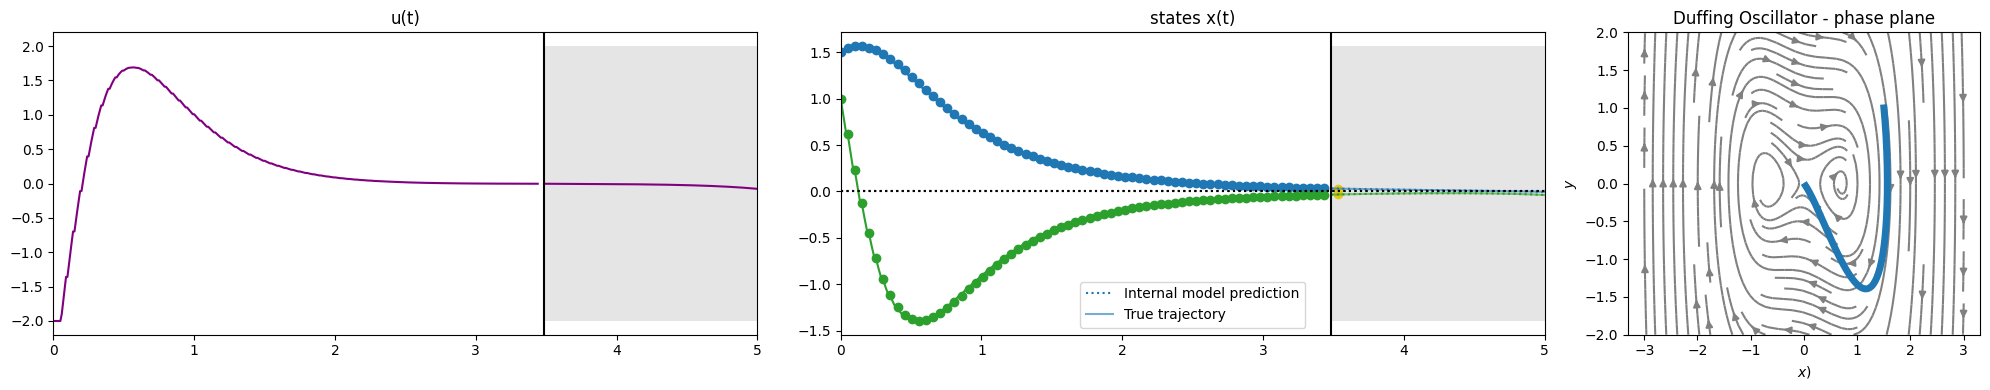

Traj. opt. times:  [(0.0236, Array(11, dtype=int64, weak_type=True)), (0.0199, Array(11, dtype=int64, weak_type=True)), (0.0203, Array(11, dtype=int64, weak_type=True)), (0.021, Array(11, dtype=int64, weak_type=True)), (0.0209, Array(11, dtype=int64, weak_type=True)), (0.0215, Array(11, dtype=int64, weak_type=True)), (0.0229, Array(11, dtype=int64, weak_type=True)), (0.0215, Array(11, dtype=int64, weak_type=True)), (0.0234, Array(11, dtype=int64, weak_type=True)), (0.0204, Array(11, dtype=int64, weak_type=True))]


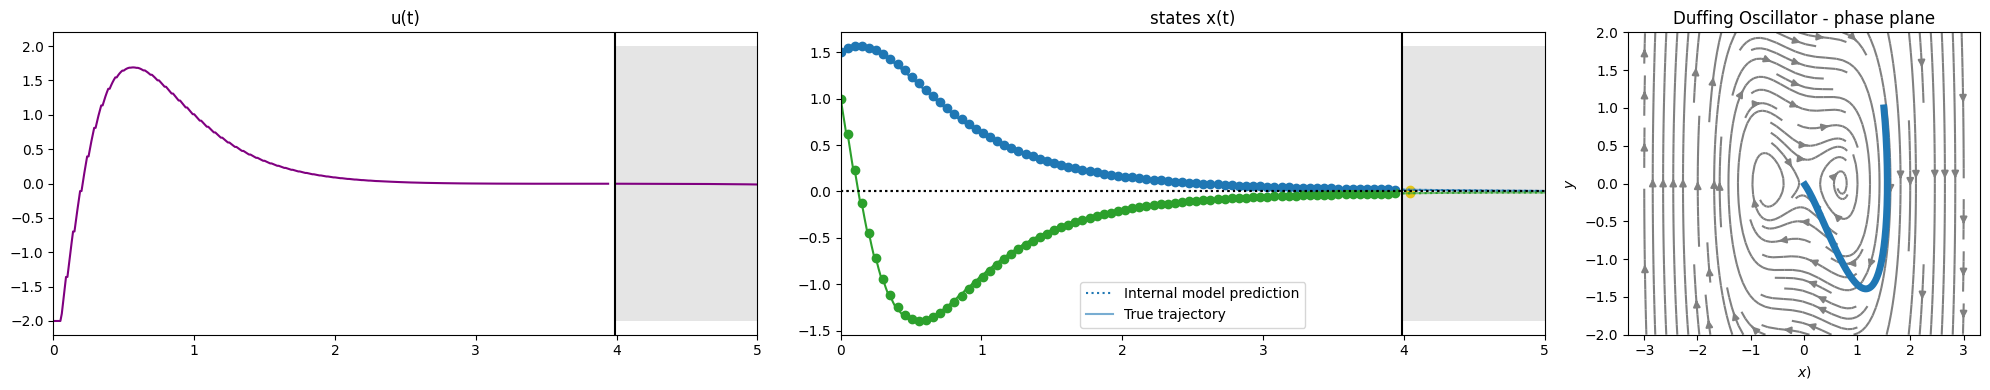

Traj. opt. times:  [(0.0618, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True)), (0.02, Array(11, dtype=int64, weak_type=True)), (0.021, Array(11, dtype=int64, weak_type=True)), (0.02, Array(11, dtype=int64, weak_type=True)), (0.0223, Array(11, dtype=int64, weak_type=True)), (0.0304, Array(11, dtype=int64, weak_type=True)), (0.0206, Array(11, dtype=int64, weak_type=True)), (0.0213, Array(11, dtype=int64, weak_type=True)), (0.0203, Array(11, dtype=int64, weak_type=True))]


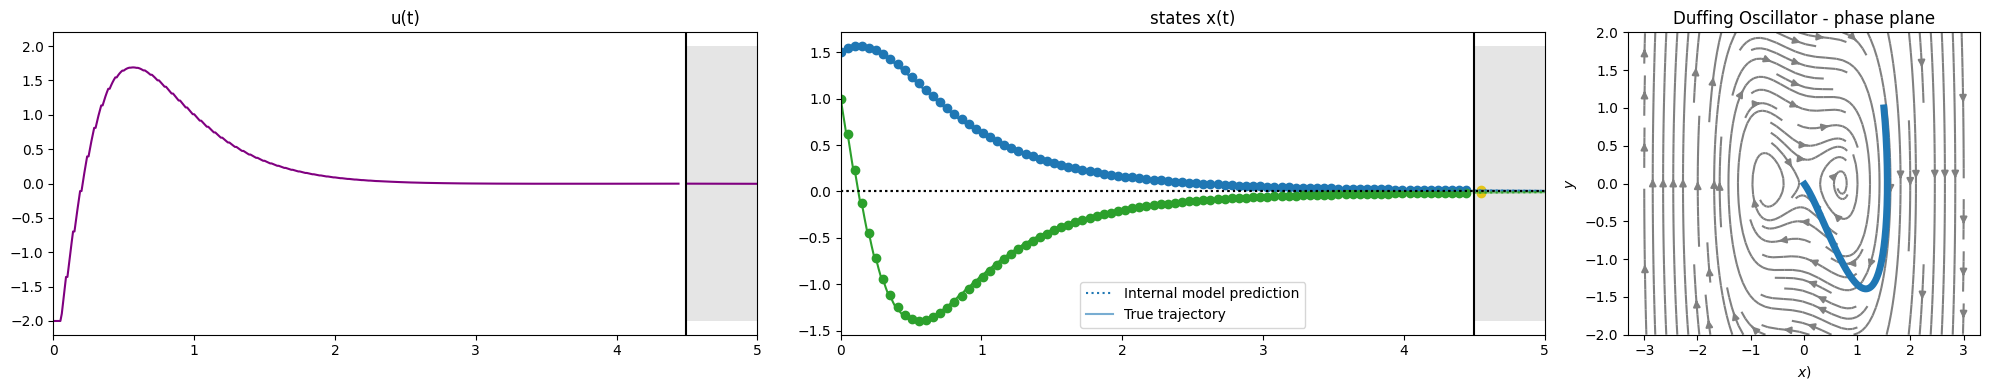

Traj. opt. times:  [(0.0441, Array(11, dtype=int64, weak_type=True)), (0.0202, Array(11, dtype=int64, weak_type=True)), (0.0208, Array(11, dtype=int64, weak_type=True)), (0.0201, Array(11, dtype=int64, weak_type=True)), (0.0197, Array(11, dtype=int64, weak_type=True)), (0.0193, Array(11, dtype=int64, weak_type=True)), (0.0193, Array(10, dtype=int64, weak_type=True)), (0.0189, Array(10, dtype=int64, weak_type=True)), (0.0189, Array(10, dtype=int64, weak_type=True)), (0.0193, Array(10, dtype=int64, weak_type=True))]


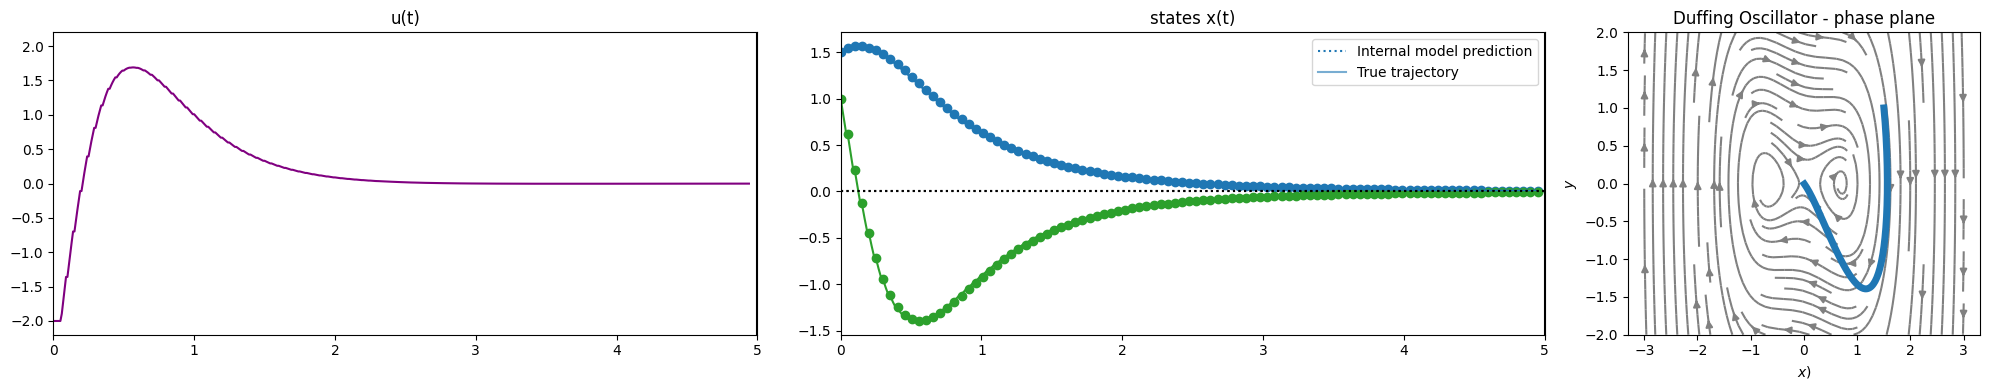

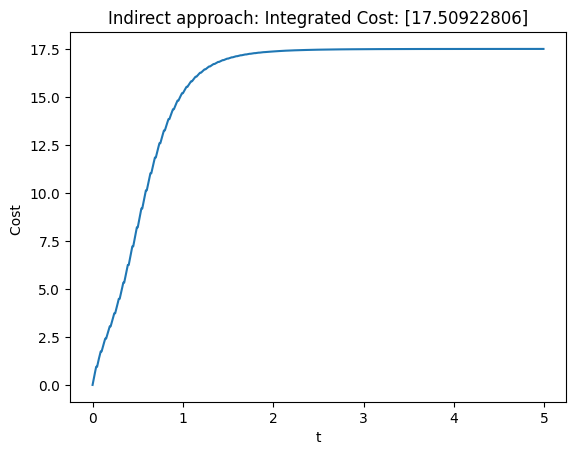

In [5]:
from gpdx.control.trajectory_optimizers import PMPForward
from gpdx.control.mpc import indirect_MPC
n_segments = 4
pmp_solver = PMPForward(f=env.real_system.f,
                maxiter=maxiter,
                D_sys=env.D_sys,
                D_control=env.D_control,
                n_segments=n_segments,
                state_cost=env.state_cost,
                termination_cost=env.termination_cost,
                lb=env.lb*jnp.ones_like(us_init[0]),
                ub=env.ub*jnp.ones_like(us_init[0]),
                )
        
indirect_mpc = indirect_MPC(traj_optimizer=pmp_solver,
    real_system=env.real_system,
    internal_system=env.real_system,
    state_cost=env.state_cost,
    termination_cost=env.termination_cost,
    verbose=True,
    )

ts, ts_dense, X, Y, U, R = indirect_mpc.simulate(x0=env.get_initial_condition(),
    ts=jnp.linspace(env.t0, env.tf, int( ((1/env.Delta_t))*(tf-t0))),
    Delta_t=env.Delta_t,
    dt0_internal=0.05,
    dt0_dense=1e-2,
    x_star=env.x_star,
    H=H,
    key=jr.PRNGKey(44))

plt.plot(ts_dense, R)
plt.title(f'Indirect approach: Integrated Cost: {R[-1]}')
plt.ylabel('Cost ')
plt.xlabel('t')
plt.show()

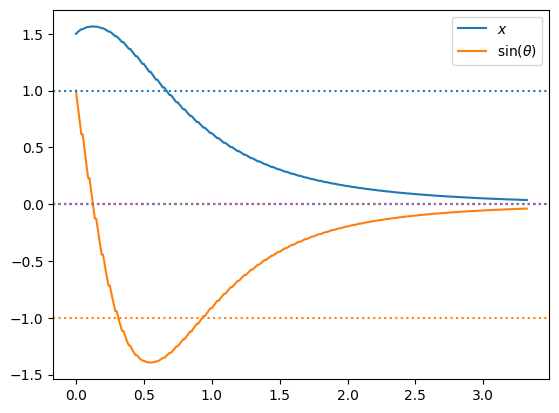

In [6]:
end_idx = int(ts_dense.shape[0]/1.5)
names = [r'$x$', r'$\sin(\theta)$', r'$\cos(\theta)$', r'$\dot{x}$', r'$\dot{\theta}$']
for i in range(env.D_sys):
    plt.plot(ts_dense[:end_idx], X[:end_idx,i], label=names[i])
plt.axhline(y=1., color='C0', linestyle=':')
plt.axhline(y=-1, color='C1', linestyle=':')
plt.axhline(y=0., color='C2', linestyle=':')
plt.axhline(y=0., color='C3', linestyle=':')
plt.axhline(y=0., color='C4', linestyle=':')
plt.legend()
plt.show()